# PyTorch Workflow: Linear Regression End-to-End

This notebook covers the full linear regression workflow in PyTorch with practical intuition and coding exercises.


## Topics Covered

1. Creating a dataset with linear regression
2. Creating training and test sets
3. Creating our first PyTorch model
4. Important model-building classes
5. Checking model internals
6. Making predictions with our model
7. Training a model with PyTorch (intuition)
8. Setting up a loss function and optimizer
9. Training loop intuition
10. Running training loop epoch by epoch
11. Writing testing loop code
12. Saving and loading a model
13. Putting everything together


## Learning Goals

By the end, you should be able to:
- Build synthetic regression data with known true parameters.
- Split data into train/test sets correctly.
- Define an `nn.Module` model for regression.
- Train and evaluate with proper `train()` / `eval()` behavior.
- Save and reload model weights safely.
- Package the whole process into reusable functions.


In [9]:
# Import essential PyTorch components for building neural networks
import torch  # Core PyTorch library
from torch import nn  # Neural network modules (Linear, Loss functions, etc.)
import matplotlib.pyplot as plt  # Visualization library

print('Torch version:', torch.__version__)

Torch version: 2.10.0


In [10]:
# Set random seed for reproducibility: same seed = same random numbers
# This ensures consistent results across runs, crucial for debugging and comparing experiments
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

## Creating a Dataset with Linear Regression

We build a synthetic dataset from the formula:

\[
y = w x + b
\]

Since we choose `w` and `b`, we can verify whether training recovers those values.


In [11]:
# Create synthetic linear regression data with known true parameters
# By knowing the true weight and bias, we can verify whether training recovers them
weight_true = 0.7
bias_true = 0.3

# Create input values (independent variable): 50 evenly spaced values from 0 to 1
# unsqueeze(dim=1) reshapes from (50,) to (50, 1) - converts 1D to 2D column vector
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)

# Create labels using the true linear relationship: y = weight*x + bias
# This creates perfect linear data with no noise
y = weight_true * X + bias_true

print('X shape:', X.shape)  # Should be (50, 1)
print('y shape:', y.shape)  # Should be (50, 1)

X shape: torch.Size([50, 1])
y shape: torch.Size([50, 1])


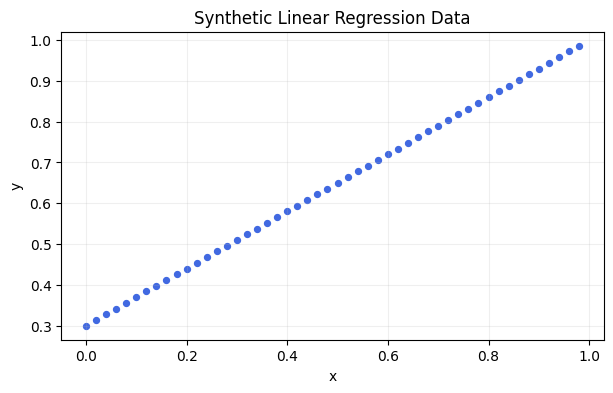

In [12]:
# Visualize the synthetic dataset to understand the relationship
# This shows the true linear relationship our model will try to learn
plt.figure(figsize=(7, 4))
plt.scatter(X.numpy(), y.numpy(), s=18, c='royalblue')  # .numpy() converts tensor to NumPy for plotting
plt.title('Synthetic Linear Regression Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(alpha=0.2)
plt.show()

### Exercise 1

- Change `weight_true` and `bias_true`.
- Regenerate `y`.
- Re-plot the data and describe how slope/intercept changed.


## Creating Training and Test Sets

A model should be trained on one subset and evaluated on unseen examples.


In [13]:
# Split data into training and test sets (80/20 split is common)
# Training data: used to optimize model parameters (weight & bias)
# Test data: held out to evaluate generalization to unseen examples
train_split = int(0.8 * len(X))  # Calculate split point (80% of data)
X_train, y_train = X[:train_split], y[:train_split]  # First 80%
X_test, y_test = X[train_split:], y[train_split:]  # Last 20%

print('Train samples:', len(X_train))
print('Test samples :', len(X_test))

Train samples: 40
Test samples : 10


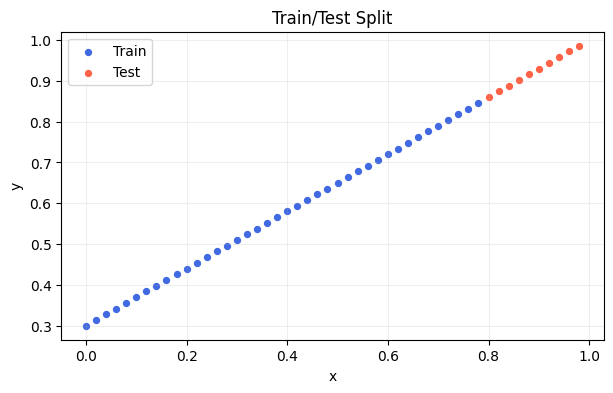

In [14]:
# Visualize the train/test split to confirm data partitioning
plt.figure(figsize=(7, 4))
plt.scatter(X_train.numpy(), y_train.numpy(), s=18, c='royalblue', label='Train')
plt.scatter(X_test.numpy(), y_test.numpy(), s=18, c='tomato', label='Test')
plt.legend()
plt.title('Train/Test Split')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(alpha=0.2)
plt.show()

### Exercise 2

- Try split ratios `70/30` and `90/10`.
- Compare how many test points each gives.
- Which split gives a stronger estimate of generalization for this small dataset?


## Creating Our First PyTorch Model

We start with the most explicit version: two learnable parameters (`weight`, `bias`) as `nn.Parameter` objects.


In [ ]:
# Define a neural network model for linear regression (explicit version)
# nn.Module is the base class for all PyTorch models
# We explicitly define weight and bias as nn.Parameter (learnable tensors)
class LinearRegressionModelV1(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize parent nn.Module class
        # nn.Parameter marks tensors as learnable - optimizer will update these
        # Initialize with random values (optimizer will adjust them during training)
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))

    # forward() defines how data flows through the model
    # Prediction: y = weight * x + bias (linear regression equation)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


model_0 = LinearRegressionModelV1()
print(model_0)

LinearRegressionModelV1()


## Important Model-Building Classes

- `nn.Module`: Base class for all neural network modules.
- `nn.Parameter`: Tensor that should be optimized.
- `nn.Linear`: Built-in affine layer (`y = xA^T + b`).
- `torch.optim`: Optimizers like SGD/Adam.
- Loss functions: quantify prediction error (`nn.L1Loss`, `nn.MSELoss`, etc.).


In [ ]:
# Alternative model using nn.Linear (more practical for larger networks)
# nn.Linear is a built-in layer that automatically manages weight and bias
# in_features=1: expects 1 input (x value)
# out_features=1: produces 1 output (y prediction)
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Linear automatically creates and manages weight and bias parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


model_1 = LinearRegressionModelV2()
print(model_1)

### Exercise 3

- Print both `model_0` and `model_1` parameters.
- Explain how `model_1` hides `weight`/`bias` inside `nn.Linear`.


## Checking Out the Internals of Our Model


In [ ]:
# Inspect model_0 internals: parameters are what the optimizer will update
# named_parameters() returns (name, tensor) pairs for all learnable parameters
print('model_0 parameters:')
for name, param in model_0.named_parameters():
    print(f'{name:10s} | shape={tuple(param.shape)} | value={param.data}')

# state_dict() is a dictionary containing all learnable parameters
# Used for saving/loading models
print('\nmodel_0 state_dict:')
print(model_0.state_dict())

In [ ]:
# Compare model_1 parameters: nn.Linear hides weight and bias inside the layer
# Notice: parameters are named 'linear_layer.weight' and 'linear_layer.bias'
print('model_1 parameters:')
for name, param in model_1.named_parameters():
    print(f'{name:20s} | shape={tuple(param.shape)} | value={param.data}')

# state_dict shows the nested structure of parameters
print('\nmodel_1 state_dict:')
print(model_1.state_dict())

## Making Predictions with Our Model

Before training, predictions are usually poor because parameters are random.


In [ ]:
# Make predictions BEFORE training (parameters are still random)
# torch.inference_mode() disables gradient tracking for efficiency during evaluation
with torch.inference_mode():
    y_preds_before = model_0(X_test)

# Visualize: untrained model predictions vs actual test values
plt.figure(figsize=(7, 4))
plt.scatter(X_train.numpy(), y_train.numpy(), s=18, c='royalblue', label='Train')
plt.scatter(X_test.numpy(), y_test.numpy(), s=18, c='tomato', label='Test')
plt.scatter(X_test.numpy(), y_preds_before.numpy(), s=18, c='seagreen', label='Predictions (before training)')
plt.legend()
plt.title('Predictions Before Training')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(alpha=0.2)
plt.show()

### Exercise 4

- Compare `y_preds_before[:5]` with `y_test[:5]`.
- Estimate whether the model is over- or under-predicting on average.


## Training a Model with PyTorch (Intuition)

Core cycle:
1. Forward pass (predictions)
2. Compute loss
3. Zero gradients
4. Backward pass (`loss.backward()`)
5. Optimizer step (`optimizer.step()`)


## Setting Up a Loss Function and Optimizer

For linear regression, `L1Loss` (MAE) is common in intro examples.


In [ ]:
# Define loss function and optimizer
# Loss function: L1Loss (Mean Absolute Error) - measures prediction error
# Optimizer: SGD (Stochastic Gradient Descent) - updates parameters to reduce loss
# lr (learning rate): controls step size during parameter updates (higher = bigger steps)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

## Training Loop Intuition

This short loop prints gradients to show how parameters get updated.


In [ ]:
# Training loop with gradient inspection: shows how parameters get updated
torch.manual_seed(RANDOM_SEED)
model_0.train()  # Set model to training mode (enables gradient tracking)

for step in range(3):
    # 1. Forward pass: compute predictions
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)

    # 2. Zero gradients from previous step (important!)
    # Without this, gradients accumulate and cause incorrect updates
    optimizer.zero_grad()

    # 3. Backward pass: compute gradients (dloss/dweight, dloss/dbias)
    loss.backward()

    # Print current loss and gradients to show learning progression
    print(f'Step {step} | loss={loss.item():.5f} | grad_weight={model_0.weight.grad.item():.5f} | grad_bias={model_0.bias.grad.item():.5f}')

    # 4. Optimizer step: update parameters using gradients
    # weight = weight - learning_rate * gradient
    optimizer.step()

### Exercise 5

- Increase `lr` to `0.1` and run the 3-step loop again from a fresh model.
- What changes in gradient step behavior do you observe?


## Running Our Training Loop Epoch by Epoch


In [ ]:
# Full training loop: runs many epochs with periodic evaluation
# Epoch: one complete pass through all training data

# Reinitialize model for clean training
torch.manual_seed(RANDOM_SEED)
model_0 = LinearRegressionModelV1()

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

epochs = 300  # Number of complete passes through training data
train_loss_values = []  # Track loss over time
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Training step
    model_0.train()  # Set model to training mode (enables gradient tracking)
    y_pred = model_0(X_train)  # Predictions on training data
    train_loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()  # Reset gradients
    train_loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters

    # Testing step: evaluate on unseen data WITHOUT updating parameters
    model_0.eval()  # Set model to evaluation mode (disables gradient tracking)
    with torch.inference_mode():  # Disable gradient computation for efficiency
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Log loss every 20 epochs
    if epoch % 20 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        print(f'Epoch: {epoch:3d} | Train loss: {train_loss.item():.5f} | Test loss: {test_loss.item():.5f}')

In [ ]:
# Plot training and test loss curves
# Train loss: how well model fits training data
# Test loss: generalization to unseen data (more important!)
# Good training: both losses decrease over time
plt.figure(figsize=(7, 4))
plt.plot(epoch_count, train_loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## Writing Testing Loop Code

A correct testing loop should:
- switch to `model.eval()`
- disable gradient tracking (`torch.inference_mode()`)
- compute metrics on unseen test data


In [ ]:
# Reusable evaluation function: correct testing procedure
# Key points:
# 1. model.eval() - disables dropout, batch norm, other training-specific behavior
# 2. torch.inference_mode() - disables gradient tracking for memory/speed efficiency
# 3. Evaluate on test data (NOT training data) for true generalization assessment
def evaluate_model(model: nn.Module, X_data: torch.Tensor, y_data: torch.Tensor, loss_fn):
    model.eval()  # Switch to evaluation mode
    with torch.inference_mode():  # Disable gradient tracking
        pred = model(X_data)
        loss = loss_fn(pred, y_data)
    return {'loss': loss.item(), 'predictions': pred}


test_results = evaluate_model(model_0, X_test, y_test, loss_fn)
print('Test loss:', round(test_results['loss'], 6))

In [ ]:
# Make predictions AFTER training and compare with before
with torch.inference_mode():
    y_preds_after = model_0(X_test)

# Visualize: trained model predictions should be much closer to actual values
plt.figure(figsize=(7, 4))
plt.scatter(X_train.numpy(), y_train.numpy(), s=18, c='royalblue', label='Train')
plt.scatter(X_test.numpy(), y_test.numpy(), s=18, c='tomato', label='Test')
plt.scatter(X_test.numpy(), y_preds_after.numpy(), s=18, c='seagreen', label='Predictions (after training)')
plt.legend()
plt.title('Predictions After Training')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(alpha=0.2)
plt.show()

### Exercise 6

- Add `MSELoss` to the evaluation function.
- Report both MAE and MSE for the same model.
- Which metric is larger numerically and why?


## Saving and Loading a Model

Standard practice is saving the `state_dict()`.


In [ ]:
# Save trained model weights to disk
# state_dict() contains all learnable parameters (weight, bias)
# Saving only state_dict (not entire model) is best practice: more portable, smaller file
from pathlib import Path

MODEL_PATH = Path('PyTorch Course/models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'linear_regression_model_v1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_0.state_dict(), MODEL_SAVE_PATH)
print('Saved model to:', MODEL_SAVE_PATH)

In [ ]:
# Load trained model weights from disk
# Process:
# 1. Create a fresh model instance with same architecture
# 2. Load state_dict into the new model using load_state_dict()
# 3. Set to eval mode for inference
loaded_model = LinearRegressionModelV1()  # Create new model with same architecture
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))  # Load saved weights
loaded_model.eval()  # Set to evaluation mode

# Verify loaded model produces identical predictions to the original
with torch.inference_mode():
    loaded_preds = loaded_model(X_test)

same = torch.allclose(y_preds_after, loaded_preds)  # Check if predictions are identical
print('Loaded model predictions identical to trained model:', same)

### Exercise 7

- Save `model_1` as a separate file.
- Load it into a fresh `LinearRegressionModelV2` instance.
- Verify test predictions are identical pre/post load.


## Putting Everything Together

This section wraps the workflow into reusable functions for repeatable experiments.


In [ ]:
# Reusable helper functions for the full workflow
# These functions encapsulate the workflow so we can repeat experiments with different parameters

def create_linear_data(weight=0.7, bias=0.3, start=0, end=1, step=0.02):
    """Create synthetic linear regression data with formula: y = weight*x + bias"""
    X = torch.arange(start, end, step).unsqueeze(1)
    y = weight * X + bias
    return X, y


def train_test_split_tensors(X, y, split_ratio=0.8):
    """Split tensors into training and test sets"""
    split = int(split_ratio * len(X))
    return X[:split], y[:split], X[split:], y[split:]


def train_linear_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=0.01):
    """
    Train model and return history of losses
    Returns dictionary with epoch count and loss values at each checkpoint
    """
    loss_fn = nn.L1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    history = {'epoch': [], 'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        # Training step
        model.train()  # Enable gradient tracking
        y_pred = model(X_train)
        train_loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Evaluation step
        model.eval()  # Disable gradient tracking
        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = loss_fn(test_pred, y_test)

        # Log every 20 epochs
        if epoch % 20 == 0:
            history['epoch'].append(epoch)
            history['train_loss'].append(train_loss.item())
            history['test_loss'].append(test_loss.item())

    return history

In [ ]:
# End-to-end workflow: put all reusable functions together
# Create new data with different true parameters
X_all, y_all = create_linear_data(weight=1.2, bias=-0.1)
X_train2, y_train2, X_test2, y_test2 = train_test_split_tensors(X_all, y_all, split_ratio=0.8)

# Train fresh model from scratch
torch.manual_seed(RANDOM_SEED)
final_model = LinearRegressionModelV1()

history = train_linear_model(final_model, X_train2, y_train2, X_test2, y_test2, epochs=400, lr=0.01)

# Check if learned parameters match true values (they should be close)
print('Learned weight:', final_model.weight.item())
print('Learned bias  :', final_model.bias.item())

In [ ]:
# Plot final training curves: visualize convergence
# Both train and test losses should decrease over time
# Large gap between train/test losses indicates overfitting
plt.figure(figsize=(7, 4))
plt.plot(history['epoch'], history['train_loss'], label='Train loss')
plt.plot(history['epoch'], history['test_loss'], label='Test loss')
plt.title('Final Workflow Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## Capstone Exercises

1. Add Gaussian noise to `y` when creating data and compare final losses.
2. Replace SGD with Adam and compare convergence speed.
3. Train with very small and very large learning rates and summarize failure modes.
4. Add early stopping logic when test loss does not improve for `N` checks.
5. Re-run experiments with 3 different random seeds and compare learned parameters.


## Quick Knowledge Check

- Why should test data never influence optimizer updates?
- What is the difference between `model.train()` and `model.eval()`?
- Why is `optimizer.zero_grad()` required every training step?
- What does `state_dict()` contain?
- When would you prefer MAE over MSE?
